# this notebook is used for dev purposes

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# base diffusion model will be IDDPM from https://github.com/openai/improved-diffusion/ adapted to the format of the submission
# let's get started. We going to begin implementaion from the dataset, we will use adopted food101 resized to 64x64 images

TRAIN_PATH = "/home/kolek/Edu/thesis/data/train"
TEST_PATH = "/home/kolek/Edu/thesis/data/test"

# the structure of the dataset is the following: each class of the image is places in the separate folder
# out network will be class conditioned so we need to extract this information as well

class Food101Dataset(Dataset):
    def __init__(self, directory_path, train=True):
        # get classes
        self.dataset_root = directory_path
        self.train = train
        class_names = os.listdir(directory_path)
        class_labels = range(0, len(class_names))
        # for convenience
        self.classes_to_num = {class_name:class_label for class_name, class_label in zip(class_names, class_labels)}
        self.num_to_classes = {class_label:class_name for class_name, class_label in zip(class_names, class_labels)}
        # get paths to the images
        self.image_paths = glob.glob(self.dataset_root + "/*/*")


        
    def __getitem__(self, idx):
        # load image and convert it to RGB
        image = Image.open(self.image_paths[idx])
        image = np.array(image.convert("RGB"))
        # normalize image to range [-1, 1]
        image = image.astype(np.float32) / 127.5 - 1
        # then convert to torch tensor
        image = torch.tensor(image, dtype=torch.float32)
                
        # deduct class label from path
        image_class = self.image_paths[idx].split("/")[-2]

        # to comply with improved diffusion unet channels should be
        # a first dimension and labels should be returns as a dict
        return image.permute([2, 0, 1]), {"y": self.classes_to_num[image_class]}

    def __len__(self):
        return len(self.image_paths)

In [3]:
dataset = Food101Dataset(TRAIN_PATH)

/home/kolek/Edu/thesis/data/train/beef_tartare/3599238.jpg 0.0 255.0


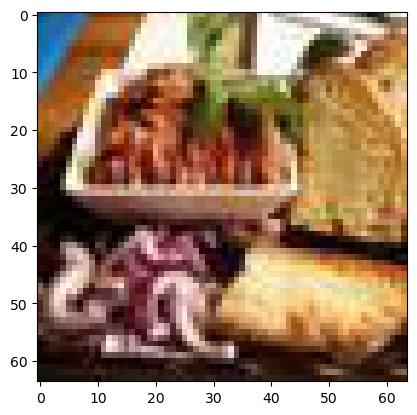

In [4]:
# test
idx = 2
img, label = dataset[idx]
rgb = (img * 127.5 + 127.5).numpy().transpose([1, 2, 0])
print(dataset.image_paths[idx], rgb.min(), rgb.max())
plt.imshow(rgb.astype(np.uint8))

In [5]:
def plot_image_distributions(dataset):
    counter = {class_name:0 for class_name in dataset.classes_to_num.keys()}
    for path in dataset.image_paths:
    # exctract label value 
        class_name = path.split("/")[-2]
        counter[class_name] += 1
    # Example data
    classes = dataset.classes_to_num.keys()
    y_pos = np.arange(len(classes))
    number_of_images = counter.values()

    fig, ax = plt.subplots(figsize=(18, 18))
    hbars = ax.barh(y_pos, number_of_images, align='center')
    ax.set_yticks(y_pos, labels=classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Number of images')
    ax.set_title('How many images per each label')

    # Label with specially formatted floats
    ax.bar_label(hbars, fmt='%.2f')
    ax.set_xlim(right=1000)  # adjust xlim to fit labels

    plt.show()

In [6]:
#plot_image_distributions(dataset)

> Roughly the same per each class

In [7]:
from models.improved_diffusion.unet import UNetModel

def create_model(
    image_size,
    num_channels,
    num_res_blocks,
    learn_sigma,
    class_cond,
    use_checkpoint,
    attention_resolutions,
    num_heads,
    num_heads_upsample,
    use_scale_shift_norm,
    dropout,
    num_classes
):
    if image_size == 256:
        channel_mult = (1, 1, 2, 2, 4, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    elif image_size == 32:
        channel_mult = (1, 2, 2, 2)
    else:
        raise ValueError(f"unsupported image size: {image_size}")

    attention_ds = []
    for res in attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))

    return UNetModel(
        in_channels=3,
        model_channels=num_channels,
        out_channels=(3 if not learn_sigma else 6),
        num_res_blocks=num_res_blocks,
        attention_resolutions=tuple(attention_ds),
        dropout=dropout,
        channel_mult=channel_mult,
        num_classes=(num_classes if class_cond else None),
        use_checkpoint=use_checkpoint,
        num_heads=num_heads,
        num_heads_upsample=num_heads_upsample,
        use_scale_shift_norm=use_scale_shift_norm,
    )

In [8]:
from models.improved_diffusion import gaussian_diffusion as gd
from models.improved_diffusion.respace import SpacedDiffusion, space_timesteps

def create_gaussian_diffusion(
    *,
    steps=1000,
    learn_sigma=False,
    noise_schedule="linear",
    use_kl=False,
    predict_xstart=False,
    rescale_timesteps=False,
    rescale_learned_sigmas=False,
    timestep_respacing="",
    sigma_small
):
    betas = gd.get_named_beta_schedule(noise_schedule, steps)
    if use_kl:
        loss_type = gd.LossType.RESCALED_KL
    elif rescale_learned_sigmas:
        loss_type = gd.LossType.RESCALED_MSE
    else:
        loss_type = gd.LossType.MSE
    if not timestep_respacing:
        timestep_respacing = [steps]
    return SpacedDiffusion(
        use_timesteps=space_timesteps(steps, timestep_respacing),
        betas=betas,
        model_mean_type=(
            gd.ModelMeanType.EPSILON if not predict_xstart else gd.ModelMeanType.START_X
        ),
        model_var_type=(
            (
                gd.ModelVarType.FIXED_LARGE
                if not sigma_small
                else gd.ModelVarType.FIXED_SMALL
            )
            if not learn_sigma
            else gd.ModelVarType.LEARNED_RANGE
        ),
        loss_type=loss_type,
        rescale_timesteps=rescale_timesteps,
    )


In [9]:
def model_defaults():
    """
    Defaults for image training.
    """
    return dict(
        image_size=64,
        num_channels=128,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        attention_resolutions="16,8",
        dropout=0.0,
        learn_sigma=False,
        class_cond=True,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        num_classes = 101
    )


def diffusion_defaults():
    """
    Defaults for diffusion process
    """
    return dict(
        sigma_small=False,
        steps=1000,
        noise_schedule="linear",
        timestep_respacing="",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=True,
        rescale_learned_sigmas=True,
    )

In [10]:
# lets construct out first diffusion model
# we need to create:
# > model for reverse diffusion process
# > straight diffusion process
# > noise scheduler 

from models.improved_diffusion.scheduler import UniformSampler

# def calculate_number_of_trainable_params(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# model = create_model(
#     **model_defaults()
# ).to(DEVICE)

# diffusion = create_gaussian_diffusion(**diffusion_defaults())

# scheduler = UniformSampler(diffusion)
# print(f"number of trainable params: {calculate_number_of_trainable_params(model)}")

In [11]:
# # create a dataloader
# dataloader = DataLoader(dataset=dataset, shuffle=True, batch_size=2)
# batch = next(iter(dataloader))
# images, labels = batch

In [12]:
# optimizer = torch.optim.AdamW(model.parameters())

In [13]:
# Let's define a training step
# get batch
def train_step(model, diffusion, optimizer, batch, device):
    model.train()
    optimizer.zero_grad()
    images, labels = batch
    images = images.to(device)
    labels['y'] = labels['y'].to(device)
    # sample timesteps for the batch
    # returns timesteps per each sample in the batch and weights for each timestamp
    # in case of uniform scheduler weights for each timestamp is equal to 1
    t, weights = scheduler.sample(images.shape[0], device)

    # internally this function:
    # > generate random noise to apply to the image
    # > does straight diffusion process with this noise
    # > gets the output from the model
    # > calculated loss
    losses = diffusion.training_losses(model=model, x_start=images, t=t, model_kwargs=labels)

    # loss: could be KL or MSE, or rescaled ones. Default rescaled MSE
    loss = losses["loss"].mean()


    loss.backward()
    # TODO add annealing
    optimizer.step()


In [14]:
#train_step(model, diffusion, optimizer, batch, DEVICE)

In [15]:
# Let's define how to sample from model
# in order to sample we need diffusion class, model and labels

def sample(model, diffusion, shape, labels, device):
    model.eval()
    with torch.no_grad():
        samples = diffusion.p_sample_loop(model, shape, model_kwargs=labels, device=device)
    return samples


In [16]:
# samples = sample(model, diffusion, images.shape, labels, DEVICE)
# # reconstruct images from samples

# img = samples[0].permute([1, 2, 0]).detach().cpu().numpy()
# img = ((img + 1) * 127.5).astype(np.uint8)
# img = img.clip(0, 255)
# plt.title("Reconstructed img")
# plt.imshow(img)

In [17]:
# lets implement simple Trainer class

class Trainer():
    def __init__(self, model, diffusion, scheduler, dataloader, optimizer, num_epochs, device):
        self.model = model
        self.diffusion = diffusion
        self.scheduler = scheduler
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device

        self.model = self.model.to(self.device)
        self.train_loss = []
    
    def train_step(self, images, labels):
        self.model.train()
        self.optimizer.zero_grad()
        images = images.to(self.device)
        labels['y'] = labels['y'].to(self.device)
        # sample timesteps for the batch
        # returns timesteps per each sample in the batch and weights for each timestamp
        # in case of uniform scheduler weights for each timestamp is equal to 1
        t, weights = self.scheduler.sample(images.shape[0], self.device)

        # internally this function:
        # > generate random noise to apply to the image
        # > does straight diffusion process with this noise
        # > gets the output from the model
        # > calculated loss
        losses = self.diffusion.training_losses(model=self.model, x_start=images, t=t, model_kwargs=labels)

        # loss: could be KL or MSE, or rescaled ones. Default rescaled MSE
        loss = losses["loss"].mean()
        loss.backward()
        # TODO add annealing
        self.optimizer.step()
        self.train_loss.append(loss.item())


    def train_loop(self):
        
        for epoch in range(self.num_epochs):
            for (images, labels) in tqdm(self.dataloader, desc=f"Epoch: {epoch}/{self.num_epochs}"):
                self.train_step(images, labels)
                # TODO: add validation and logging

    def validation_loop(self):
        pass

In [18]:
dataloader = DataLoader(dataset=dataset, shuffle=True, batch_size=10)

model = create_model(
    **model_defaults()
).to(DEVICE)

diffusion = create_gaussian_diffusion(**diffusion_defaults())

scheduler = UniformSampler(diffusion)

optimizer = torch.optim.AdamW(model.parameters())

trainer = Trainer(model=model,
                  diffusion=diffusion,
                  scheduler=scheduler,
                  dataloader=dataloader,
                  optimizer=optimizer,
                  num_epochs=100,
                  device=DEVICE)

In [19]:
trainer.train_loop()

Epoch: 0/100:   0%|          | 0/9894 [00:00<?, ?it/s]